In [1]:
!curl 'https://raw.githubusercontent.com/glorioso/covid_predictive_analytics/main/Shared_Data/CDC-Cases-Forecast.zip?token=AFP4O6BOMOYQSD6S7R7AZFDA4SQFK' \
  -H 'authority: raw.githubusercontent.com' \
  -H 'pragma: no-cache' \
  -H 'cache-control: no-cache' \
  -H 'upgrade-insecure-requests: 1' \
  -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.106 Safari/537.36' \
  -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
  -H 'sec-fetch-site: cross-site' \
  -H 'sec-fetch-mode: navigate' \
  -H 'sec-fetch-user: ?1' \
  -H 'sec-fetch-dest: document' \
  -H 'sec-ch-ua: " Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"' \
  -H 'sec-ch-ua-mobile: ?0' \
  -H 'referer: https://github.com/' \
  -H 'accept-language: en-US,en;q=0.9,cs;q=0.8' \
  --compressed --output CDC-Cases-Forecast.zip

!unzip CDC-Cases-Forecast.zip

--2021-07-06 22:25:16--  https://github.com/glorioso/covid_predictive_analytics/blob/main/Shared_Data/CDC-Cases-Forecast.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-07-06 22:25:16 ERROR 404: Not Found.



In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt 


In [2]:
path = 'CDC-Cases-Forecast'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.target_end_date=pd.to_datetime(frame.target_end_date)

In [6]:
frame.point = frame.point/7

In [4]:
#frame.to_csv("cdc-models.csv")

In [5]:
jhu = pd.read_csv("jhu-us.csv")
jhu.Date=pd.to_datetime(jhu.Date)
jhu = jhu.set_index("Date", drop=True)
jhu = jhu.sort_index(ascending=True)
jhu["1week"] = jhu["NewCases"].rolling(7).sum()/7

In [6]:
#jhu = jhu[~jhu["1week"].isnull()]

In [8]:
models = frame["Model"].unique()
mae_list = {}
for model in models:
    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame.sort_index()
    compare_df = model_frame[(model_frame.index > "2020-12-26") & (model_frame.index < "2021-02-12")]
    compare_df["JHU"] = jhu.loc[compare_df.index]["1week"]
    if compare_df.shape[0] != 7:
        continue
    compare_df["JHU_DIFF"] = (abs(compare_df["point"] - jhu.loc[compare_df.index]["1week"]) / jhu.loc[compare_df.index]["1week"])*100
    mae = compare_df["JHU_DIFF"].mean()
    mae_list[model] = mae   

<ipython-input-8-a97ba871534d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_df["JHU"] = jhu.loc[compare_df.index]["1week"]
<ipython-input-8-a97ba871534d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_df["JHU_DIFF"] = (abs(compare_df["point"] - jhu.loc[compare_df.index]["1week"]) / jhu.loc[compare_df.index]["1week"])*100


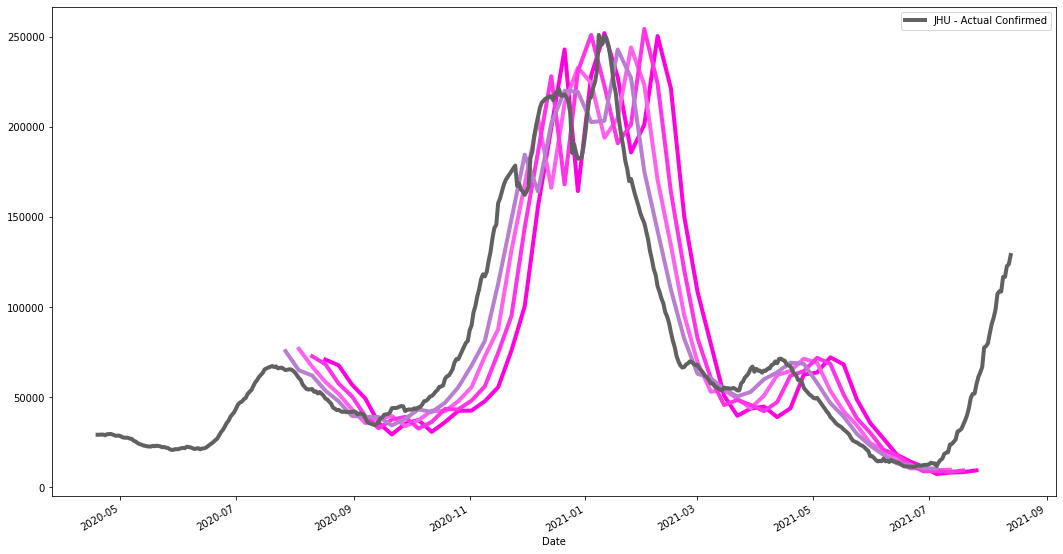

In [7]:
models = frame["Model"].unique()
fig, ax = plt.subplots()

for model in models:
    if model == "DDS-NBDS":
        continue
    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=6, color='#77d481', legend=False, label='_nolegend_')
    if model == "COVIDhub-ensemble":
        model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=4,  label='_nolegend_', color='#ff00e1')
    else:
        pass
        #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=2,  label='_nolegend_', color='#616161')
        
    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "2 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=6, color='#77d481', legend=False, label='_nolegend_')
    if model == "COVIDhub-ensemble":
        model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=4,  label='_nolegend_', color='#ff61ed')

    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "3 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=6, color='#77d481', legend=False, label='_nolegend_')
    if model == "COVIDhub-ensemble":
        model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=4,  label='_nolegend_', color='#ff33e7')        
        
        
    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "1 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=6, color='#77d481', legend=False, label='_nolegend_')
    if model == "COVIDhub-ensemble":
        model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=4,  label='_nolegend_', color='#b87ecf')

#a = christin["1week"].plot( linewidth=3,  label="Christin's Model", color='c')
b = jhu["1week"].plot( linewidth=4,  label="JHU - Actual Confirmed", color='#616161')
#a.legend()
b.legend()
#ax.legend()



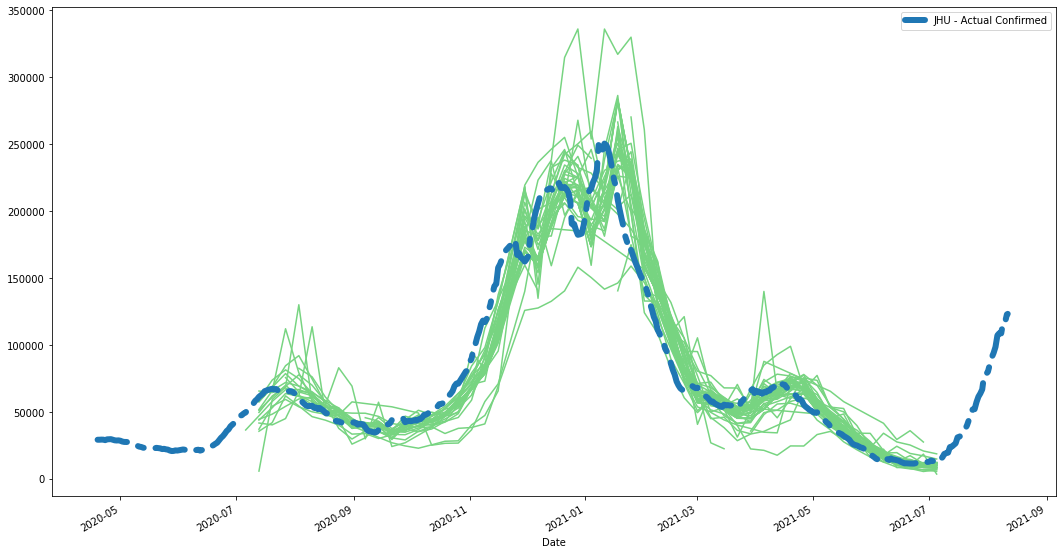

In [10]:
models = frame["Model"].unique()
fig, ax = plt.subplots()

for model in models:
    if model == "DDS-NBDS":
        continue
    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "1 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, color='#77d481', legend=False, label='_nolegend_')

b = jhu["1week"].plot( linewidth=6, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round', label="JHU - Actual Confirmed")

b.legend()


In [ ]:
models = frame["Model"].unique()
fig, ax = plt.subplots()

for model in models:
    if model == "DDS-NBDS":
        continue
    model_frame = frame[(frame["Model"]==model) & (frame["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, color='#77d481', legend=False, label='_nolegend_')

b = jhu["1week"].plot( linewidth=6, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round', label="JHU - Actual Confirmed")
b.legend()


In [71]:
len(models)

51

In [67]:
frame.sort_values("point", ascending=False)

,Model,Team Name,forecast_date,target,target_end_date,location_name,State,fips,point,quantile_0.025,quantile_0.25,quantile_0.75,quantile_0.975
5558,DDS-NBDS,Discrete Dynamical Systems,2021-03-29,1 wk ahead inc case,2021-04-05,National,National,US,3.287285e+08,608925.0,2553723.0,162708472.0,328728465.0
5971,DDS-NBDS,Discrete Dynamical Systems,2021-03-22,4 wk ahead inc case,2021-04-19,National,National,US,3.287285e+08,146924.0,313856.0,2430604.0,328728465.0
5970,DDS-NBDS,Discrete Dynamical Systems,2021-03-22,3 wk ahead inc case,2021-04-12,National,National,US,3.287285e+08,186848.0,340551.0,1850741.0,212636231.0
5969,DDS-NBDS,Discrete Dynamical Systems,2021-03-22,2 wk ahead inc case,2021-04-05,National,National,US,3.287285e+08,234882.0,371520.0,1391327.0,124943824.0
5968,DDS-NBDS,Discrete Dynamical Systems,2021-03-22,1 wk ahead inc case,2021-03-29,National,National,US,1.094777e+08,276311.0,382093.0,1129083.0,157614201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,OneQuietNight-ML,OneQuietNight,2021-03-08,2 wk ahead inc case,2021-03-22,National,National,US,0.000000e+00,0.0,0.0,0.0,115262.0
1243,OneQuietNight-ML,OneQuietNight,2021-03-08,3 wk ahead inc case,2021-03-29,National,National,US,0.000000e+00,0.0,0.0,0.0,140381.0
1401,OneQuietNight-ML,OneQuietNight,2021-03-01,3 wk ahead inc case,2021-03-22,National,National,US,0.000000e+00,0.0,0.0,0.0,231673.0
1402,OneQuietNight-ML,OneQuietNight,2021-03-01,4 wk ahead inc case,2021-03-29,National,National,US,0.000000e+00,0.0,0.0,0.0,428046.0


<AxesSubplot:xlabel='target_end_date'>

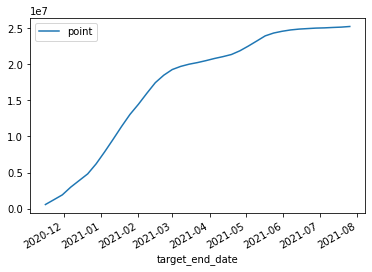